In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_absolute_error
from scipy.stats import skew, boxcox
from math import exp, log
import os
from os import listdir
import csv
from sklearn.ensemble import RandomForestRegressor as RandomForest
%matplotlib inline
import pylab
from matplotlib.mlab import PCA as mlabPCA
import matplotlib.pyplot as plt
import math
import pickle
from sklearn.cross_validation import KFold
from sklearn import cross_validation
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
import sklearn
from sklearn.preprocessing import normalize
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
from keras.layers.advanced_activations import PReLU
from keras.models import load_model
from keras.layers import Convolution1D, GlobalMaxPooling1D, Merge
import cPickle
from sklearn.externals import joblib
np.random.seed(123)

Using Theano backend.


In [2]:
def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]
    
    # sort rows on prediction column 
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:,0].argsort()][::-1,0]
    pred_order = arr[arr[:,1].argsort()][::-1,0]
    
    # get Lorenz curves
    L_true = np.cumsum(true_order) / np.sum(true_order)
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    L_ones = np.linspace(1/n_samples, 1, n_samples)
    
    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)
    
    # normalize to true Gini coefficient
    return G_pred/G_true

In [3]:
def perf_measure(y_actual,y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if np.all(y_actual[i]==1 and y_hat[i]==1):
            TP += 1
    for i in range(len(y_hat)): 
        if np.all(y_hat[i]==1 and y_actual[i]==0):
            FP += 1
    for i in range(len(y_hat)): 
        if np.all(y_actual[i]==0 and y_hat[i]==0):
            TN += 1
    for i in range(len(y_hat)): 
        if np.all(y_hat[i]==0 and y_actual[i]==1):
            FN += 1

    return(TP, FP, TN, FN)

In [4]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [5]:

from sklearn.metrics import accuracy_score, confusion_matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap="cool"):
    
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    target_names ="01"
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Без усреднения

### Нейронная сеть и усреднение

In [6]:
df = pd.read_csv("data_for_model_2.csv")
df = df[pd.notnull(df['bday'])]
df = df.fillna(0)
df = df[df.Product=="Cash"]
df = df.drop('Product',axis=1)
df.DTOPEN = pd.to_datetime(df.DTOPEN, format="%d%b%Y")
df.DTOPEN = df.DTOPEN.dt.year
df.bday = pd.to_datetime(df.bday, format="%d%b%Y")
df.bday = datetime.now().year-df.bday.dt.year
df = df.groupby(["Contract_ID"]).mean()
df.sx[df.sx>0.5]=1
df.sx[df.sx<1]=0

In [7]:
y = df.Class
x = df.drop(["Class",u'PTP_Amount',u'CARDS_PORTF_AVG',
       u'CARDS_PORTF_MAX', u'CARDS_BALANCEAMT_AVG', u'CARDS_BALANCEAMT_MAX',u'Total_Overdue',u'OS',u'Days_Past_Due'],axis=1)
xx = x
x.to_csv("train_avg.csv",index = None)
x = preprocessing.minmax_scale(x)
y = preprocessing.minmax_scale(y)
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

In [8]:
def nn_model():
    model = Sequential()
    model.add(Dense(20,input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(3,activation="sigmoid"))
    model.add(Dense(1,activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)
model_avg_nn = nn_model()

In [9]:
model_avg_nn.fit(X_train, y_train,validation_data=(X_test,y_test), nb_epoch=100, batch_size=8,verbose=0)

In [10]:
# evaluate the model
scores = model_avg_nn.evaluate(X_train, y_train)
print("%s: %.2f%%" % (model_avg_nn.metrics_names[1], scores[1]*100))

  32/1526 [..............................] - ETA: 0sacc: 82.96%


 32/654 [>.............................] - ETA: 0s('AUC', 0.79317969419903067)


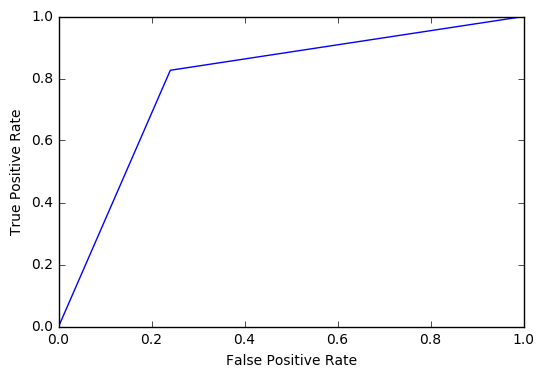

In [11]:
pre = model_avg_nn.predict_classes(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pre)
print ("AUC",metrics.auc(fpr, tpr))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

accuracy 0.7874617737
confusion matrix
 [[291  92]
 [ 47 224]]
(row=expected, col=predicted)


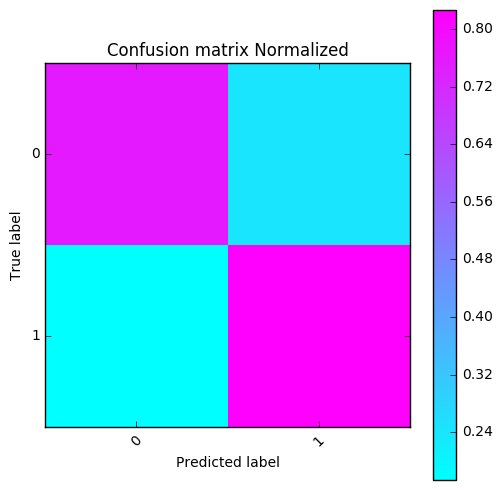

In [12]:
evaluate_prediction(pre,y_test)

In [13]:
pf = perf_measure(y_test, pre)
TP = pf[0]
FP = pf[1]
TN = pf[2]
FN = pf[3]
MCC = (TP*TN-FP*FN)/(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))**0.5)
print ('MCC', MCC)
print( "Sensivity - Recall",TP*1.0/(TP+FN))
print( "Precision",TP*1.0/(TP+FP))
print('GINI',Gini(y_test,pre[:,0]))
precision = TP*1.0/(TP+FP)
recall = TP*1.0/(TP+FN)
print("F-score",precision*recall*2.0/(precision+recall))

('MCC', 0.5780242037918004)
('Sensivity - Recall', 0.8265682656826568)
('Precision', 0.7088607594936709)
('GINI', 0.58043127306273068)
('F-score', 0.7632027257240205)


In [14]:
model_avg_nn.save('my_model_class_avg_19-12-16.h5')

### Случайный Лес

In [15]:
rfc = RandomForestClassifier(n_estimators=500)
rfc.fit(X=X_train,y=y_train)
pickle.dump(rfc,open('random_forest_avg.pkl','wb'))

('AUC', 0.78315493337700992)


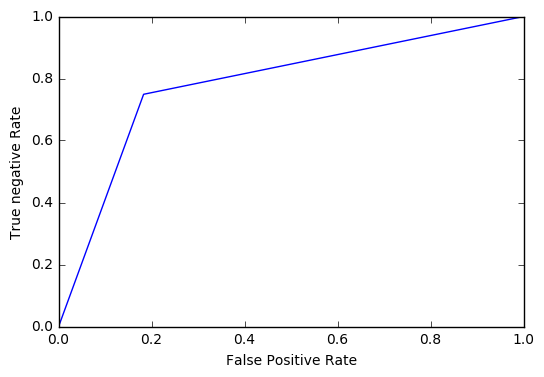

In [16]:
pre = rfc.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pre)
print ("AUC",metrics.auc(fpr, tpr))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True negative Rate")

In [17]:
pf = perf_measure(y_test, pre)
TP = pf[0]
FP = pf[1]
TN = pf[2]
FN = pf[3]
MCC = (TP*TN-FP*FN)/(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))**0.5)
print ('MCC', MCC)
print( "Sensivity - Recall",TP*1.0/(TP+FN))
print( "Precision",TP*1.0/(TP+FP))
print('GINI',Gini(y_test,pre))
precision = TP*1.0/(TP+FP)
recall = TP*1.0/(TP+FN)
print("F-score",precision*recall*2/(precision+recall))

('MCC', 0.5657106430022303)
('Sensivity - Recall', 0.7490774907749077)
('Precision', 0.7435897435897436)
('GINI', 0.57710639606396064)
('F-score', 0.7463235294117648)


accuracy 0.788990825688
confusion matrix
 [[313  70]
 [ 68 203]]
(row=expected, col=predicted)


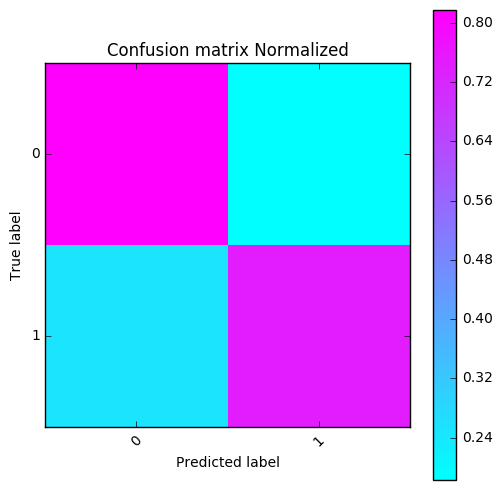

In [18]:
evaluate_prediction(pre,y_test)

### SVM

In [19]:
svc = SVC(probability=True,C=10)
svc.fit(X=X_train,y=y_train) 
pickle.dump(svc,open('svm_avg.pkl','wb'))

('AUC', 0.75316254468027699)


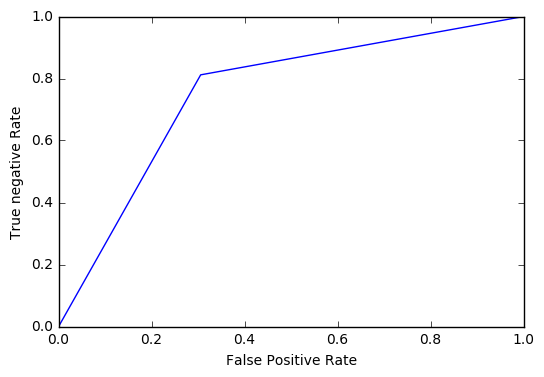

In [20]:
pre = svc.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pre)
print ("AUC",metrics.auc(fpr, tpr))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True negative Rate")

In [21]:
pf = perf_measure(y_test, pre)
TP = pf[0]
FP = pf[1]
TN = pf[2]
FN = pf[3]
MCC = (TP*TN-FP*FN)/(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))**0.5)
print ('MCC', MCC)
print( 'Sensivity',TP*1.0/(TP+FN))
print( 'Precision',TP*1.0/(TP+FP))
print('GINI',Gini(y_test,pre))
precision = TP*1.0/(TP+FP)
recall = TP*1.0/(TP+FN)
print("F-score",precision*recall*2/(precision+recall))

('MCC', 0.4990785434157292)
('Sensivity', 0.8118081180811808)
('Precision', 0.6528189910979229)
('GINI', 0.50157595325953264)
('F-score', 0.7236842105263158)


accuracy 0.743119266055
confusion matrix
 [[266 117]
 [ 51 220]]
(row=expected, col=predicted)


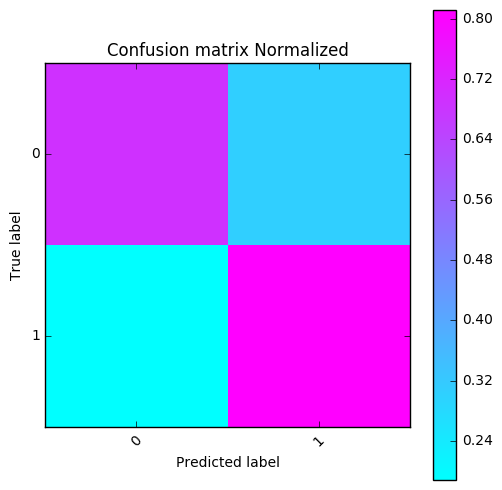

In [22]:
evaluate_prediction(pre,y_test)


### Adaboost

In [23]:
adb = AdaBoostClassifier(n_estimators=200,learning_rate=0.1)
adb.fit(X=X_train,y=y_train)
pickle.dump(adb,open('adaboost_avg.pkl','wb'))

('AUC', 0.77549545730444247)


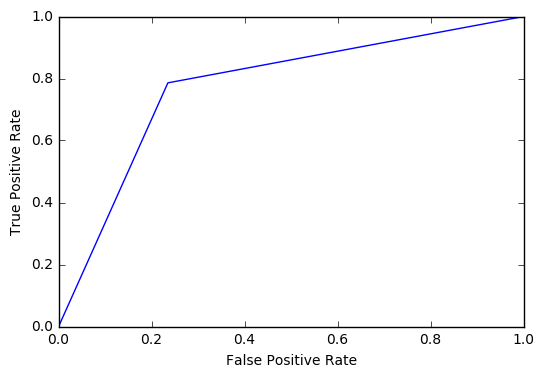

In [24]:
pre = adb.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pre)
print ("AUC",metrics.auc(fpr, tpr))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [25]:
pf = perf_measure(y_test, pre)
TP = pf[0]
FP = pf[1]
TN = pf[2]
FN = pf[3]
MCC = (TP*TN-FP*FN)/(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))**0.5)
print ('MCC', MCC)
print( 'Sensivity',TP*1.0/(TP+FN))
print( 'Precision',TP*1.0/(TP+FP))
print('GINI',Gini(y_test,pre))
precision = TP*1.0/(TP+FP)
recall = TP*1.0/(TP+FN)
print("F-score",precision*recall*2/(precision+recall))

('MCC', 0.5443191298719369)
('Sensivity', 0.7859778597785978)
('Precision', 0.7029702970297029)
('GINI', 0.56159670971709719)
('F-score', 0.7421602787456446)


In [26]:
Gini(y_test,pre)

0.56159670971709719

accuracy 0.77370030581
confusion matrix
 [[293  90]
 [ 58 213]]
(row=expected, col=predicted)


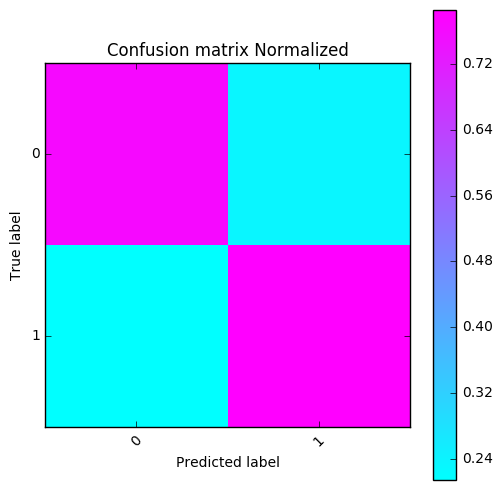

In [27]:
evaluate_prediction(pre,y_test)

### Логистическая регрессия

accuracy 0.776758409786
confusion matrix
 [[315  68]
 [ 78 193]]
(row=expected, col=predicted)


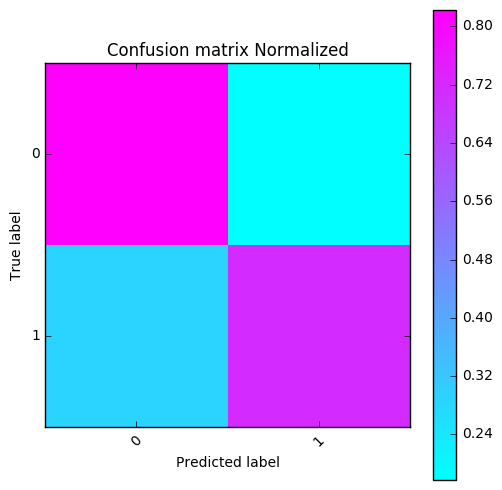

In [28]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(n_jobs=30, C=1e7)
logreg = logreg.fit(X_train, y_train) ### учим регрессию
pre =logreg.predict(X_test)
evaluate_prediction(pre, y_test) 


('AUC', 0.7673157149326062)


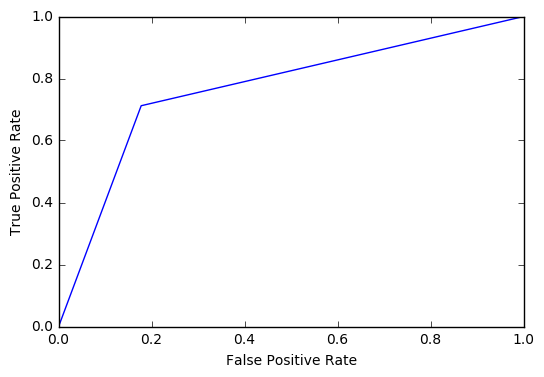

In [29]:
pre =logreg.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pre)
print ("AUC",metrics.auc(fpr, tpr))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [30]:
pf = perf_measure(y_test, pre)
TP = pf[0]
FP = pf[1]
TN = pf[2]
FN = pf[3]
MCC = (TP*TN-FP*FN)/(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))**0.5)
print ('MCC', MCC)
print( 'Sensivity',TP*1.0/(TP+FN))
print( 'Precision',TP*1.0/(TP+FP))
print('GINI',Gini(y_test,pre))
precision = TP*1.0/(TP+FP)
recall = TP*1.0/(TP+FN)
print("F-score",precision*recall*2/(precision+recall))

('MCC', 0.5378014762328451)
('Sensivity', 0.7121771217712177)
('Precision', 0.7394636015325671)
('GINI', 0.52755996309963105)
('F-score', 0.7255639097744362)


In [31]:
pickle.dump(logreg,open('logreg.pkl','wb'))

### Модель второго уровня

In [39]:
model_avg_nn2nd.save('my_model_class_avg_2ndlevel_19-12-16.h5')

### Усреднение весов

In [167]:
pred_test = pre2*0.1 + pre_nn[:,0]*0.85+pre_logreg_test[:,1]*0.05

In [185]:
pf = perf_measure(y_test, predt)
TP = pf[0]
FP = pf[1]
TN = pf[2]
FN = pf[3]
MCC = (TP*TN-FP*FN)/(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))**0.5)
print ('MCC', MCC)
print( "Sensivity - Recall",TP*1.0/(TP+FN))
print( "Precision",TP*1.0/(TP+FP))
print('GINI',Gini(y_test,pre[:,0]))
precision = TP*1.0/(TP+FP)
recall = TP*1.0/(TP+FN)
print("F-score",precision*recall*2.0/(precision+recall))

('MCC', 0.6010351617065092)
('Sensivity - Recall', 0.8339483394833949)
('Precision', 0.7243589743589743)
('GINI', 0.59371156211562126)
('F-score', 0.7753001715265867)


accuracy 0.799694189602
confusion matrix
 [[297  86]
 [ 45 226]]
(row=expected, col=predicted)


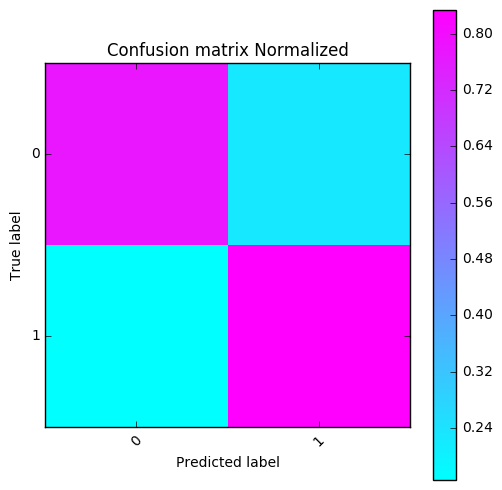

In [184]:
evaluate_prediction(predt,y_test)